## Exploring a single simulation

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from copy import copy
from datetime import timedelta

In [4]:
datadir = '/scratch/rfischer/Kooi_data/data_output/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [5]:
r_pl_clist = ['#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
r_pl_cmap = plt.get_cmap('RdPu')

In [6]:
region = 'EqPac'
mortality = 0.39              # [d-1]
runtime = 170                  # [days]
dt = 60                       # [seconds]
outputdt = 12                 # [hours]
mixing = 'markov_0_KPP_reflectsudden_tidal'
rho_p = 920
sizebinedges = [5e-3, 5e-4, 5e-5, 5e-6, 5e-7]
res = '1x1'
proc = 'bfnoadv'

In [7]:
# ds = xr.open_dataset(datadir+'regional_'+region+'_bfadv_Jan_2004_0'+str(mortality)[2:]+'mort_'+mixing+'mixing_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')
ds = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [8]:
times = ds['time'][0,:].astype('O')
timelabels = ds['time'][0,:].dt.strftime('%Y-%m-%d')

In [12]:
number_of_trajectories_to_plot = 10000
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 10000 of 10000 trajectories
plotting every 1 particles


In [13]:
lons = copy(ds['lon'][:].values)
lats = copy(ds['lat'][:].values)
depths = copy(ds['z'][:].values)
sizes = copy(ds['r_pl'][:].values)
sizecolors = (np.log10(sizes)-np.log10(sizes.min()))*256/(np.log10(sizes.max())-np.log10(sizes.min()))

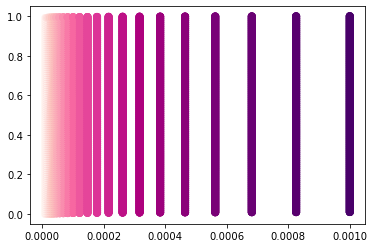

In [11]:
c= r_pl_cmap(sizecolors.astype(int))
plt.scatter(sizes,np.linspace(0,1,len(c)),s=50,color=c)

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


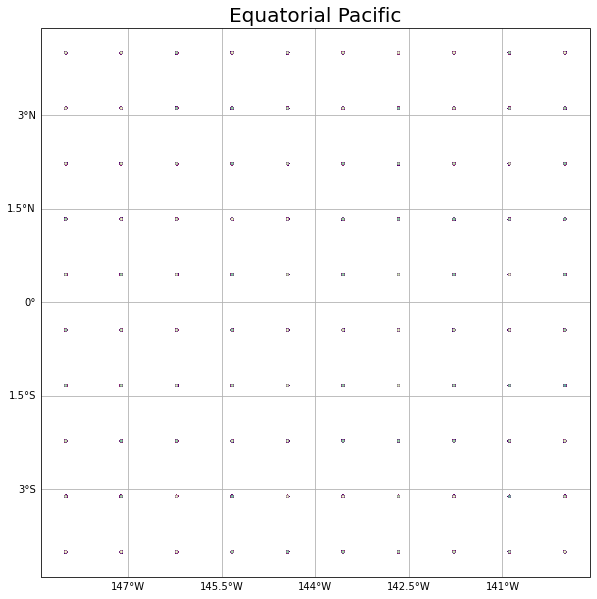

In [11]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.set_title(regions[region], fontsize=20)
c= r_pl_cmap(sizecolors.astype(int))
ax.scatter(lons,lats,c=depths,cmap='cmo.deep',s=7, edgecolors=c,linewidth=0.2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([165,240,-15,15], crs=ccrs.PlateCarree())
# ax.set_ylim(np.mean(ds['lat'])-15,np.mean(ds['lat'])+15)
# ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-45+180,np.mean(ds['lon'].where(ds['lon']<0))+26+180)
# ax.set_xlim(np.mean(ds['lon'])-15,np.mean(ds['lon'])+30)
plt.show()

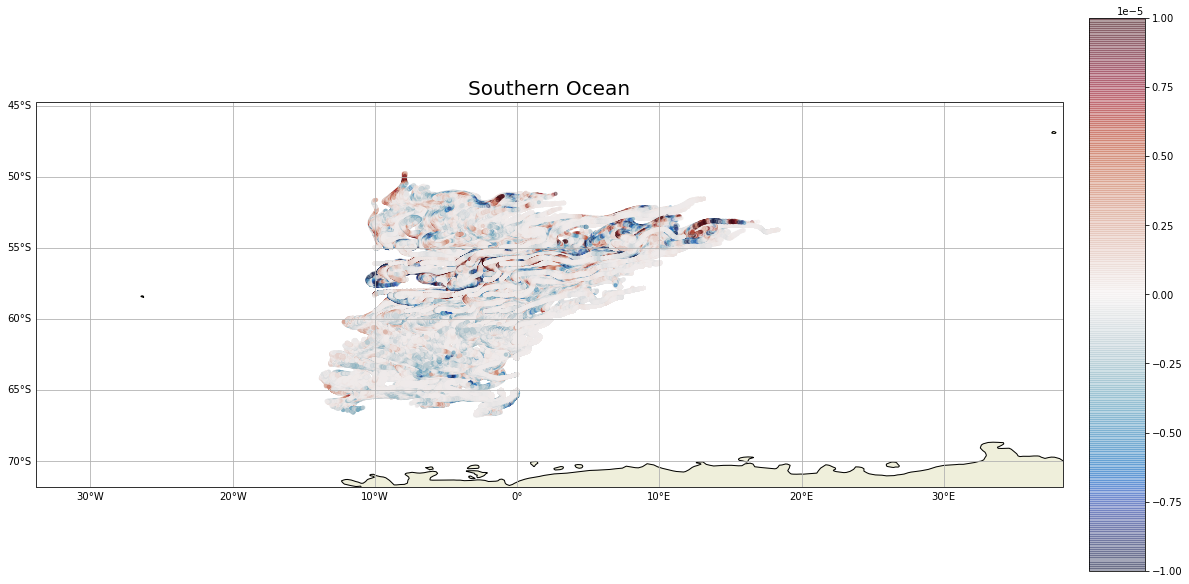

In [35]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_title(regions[region], fontsize=20)
sc = ax.scatter(ds['lon'],ds['lat'],c=ds['w_adv'],cmap='cmo.balance',s=10,alpha=0.4,vmin=-1e-5,vmax=1e-5)
ax.coastlines()
ax.add_feature(cfeature.LAND)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.set_ylim(np.min(ds['lat'])-5,np.max(ds['lat'])+5)
ax.set_xlim(np.min(ds['lon'])-20,np.max(ds['lon'])+20)

plt.colorbar(sc)
plt.show()

In [23]:
outputdt = timedelta(hours=12)

timerange = np.arange(np.nanmin(ds['time'].values),
                      np.nanmax(ds['time'].values)+np.timedelta64(outputdt),
                      outputdt)  # timerange in nanoseconds\n",
    
timedays = np.zeros(len(timerange), dtype='<U10')
for i in range(len(timerange)):
    timedays[i] = str(timerange[i])[:10]
timedays = np.unique(timedays)

In [24]:
time_id = np.where(np.logical_and(ds['time'] >= timerange[0],ds['time'] < timerange[1])) # All trajectory data for a single day

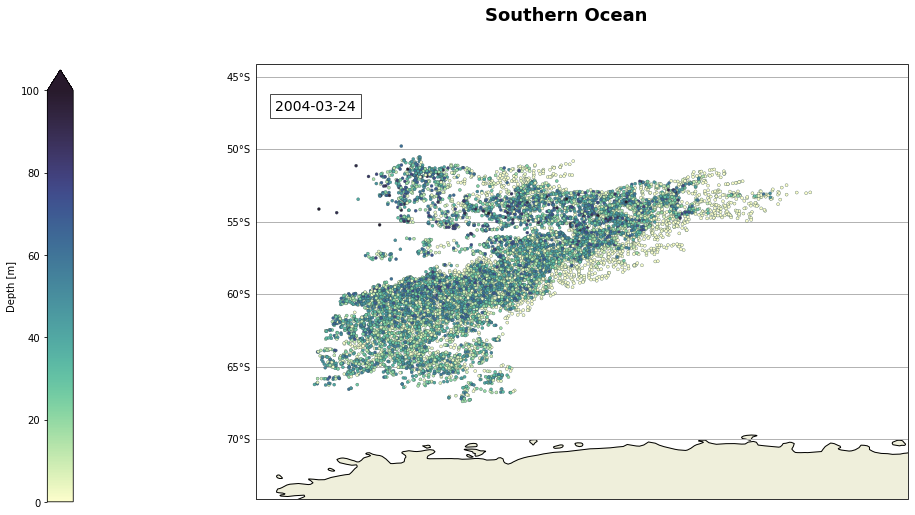

In [25]:
fig = plt.figure(figsize=(18,8))
fig.suptitle(regions[region], fontsize=18, fontweight='bold')
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_ylim(np.mean(ds['lat'])-15,np.mean(ds['lat'])+15)
# ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-45+180,np.mean(ds['lon'].where(ds['lon']<0))+26+180)
ax.set_xlim(np.mean(ds['lon'])-15,np.mean(ds['lon'])+30)
# ax.set_yticks([-50, -40, -30, -20], crs=ccrs.PlateCarree())
# ax.set_yticklabels(['50$^{\\circ}$S', '40$^{\\circ}$S', '30$^{\\circ}$S', '20$^{\\circ}$S'])
# ax.set_ylabel('Latitude', fontsize=11, fontweight='bold')

# ax.set_xticks([-50, -40, -30, -20, -10, 0, 10, 20], crs=ccrs.PlateCarree())
# ax.set_xticklabels(['50$^{\\circ}$W', '40$^{\\circ}$W', '30$^{\\circ}$W', '20$^{\\circ}$W', '10$^{\\circ}$W', '0$^{\\circ}$E', '10$^{\\circ}$E', '20$^{\\circ}$E'])
# ax.set_xlabel('Longitude', fontsize=11, fontweight='bold')

# depth = ax.pcolormesh(lon_bath_corners, lat_bath_corners, Depth, cmap=b_cmap,vmax =5000,zorder=2)
# ax.pcolormesh(lon_corners, lat_corners, speed, cmap=f_cmap,zorder=1)

# ax.pcolor(lon_corners, lat_corners, Coast,cmap=c_cmap,hatch='//',edgecolor='coral',zorder=3)
# coastcells = mpatches.Patch(facecolor='w',hatch='//',edgecolor='coral', label='Coastal cells')

ax.coastlines()
ax.add_feature(cfeature.LAND)

ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,200,220,240])
gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,-160,-140,-120])
gl.top_labels = False
gl.right_labels = False
# gl.xlocator = mticker.FixedLocator([180, -])
# gl.ylocator = LatitudeLocator()
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()


time_id = np.where(np.logical_and(ds['time'] >= timerange[0],ds['time'] < timerange[1])) # All trajectory data for a single day

edgecolors= r_pl_cmap(sizecolors.astype(int))
# initial = ax.scatter(ds['lon'][:,0],ds['lat'][:,0],c='w',edgecolor='orangered',s=100,zorder=3)
scatter = ax.scatter(lons[time_id].T,lats[time_id].T,c=depths[time_id].T,cmap='cmo.deep',s=9, edgecolor='darkslategray',linewidth=0.3,vmin=0,vmax=100, transform=ccrs.PlateCarree(),zorder=4)

# time_id_TDC = np.where(np.logical_and(TDCdata['time'] >= timerange[0],TDCdata['time'] < timerange[24])) # All trajectory data for a single day

# site_TDC = ax.scatter(lons_TDC[1,0],lats_TDC[1,0],c='w',edgecolor='seagreen',s=100,zorder=3)
# scatter_TDC = ax.scatter(lons_TDC[time_id_TDC].T,lats_TDC[time_id_TDC].T,c=launch_TDC[time_id_TDC],cmap=p_cmap,vmin=-0.5,vmax=0.5,alpha=0.4,edgecolor='seagreen',zorder=4)

# N_site = ax.scatter(lonsN[0,0].T,latsN[0,0].T,c='w',edgecolor='r',s=40,zorder=3)

time_text = ax.text(0.03, 0.92,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}) # Initialise time ticker

## Depth colorbar
axcb = fig.add_axes([0.1, 0.12, 0.02, 0.75])
CB = plt.colorbar(scatter, cax=axcb,label='Depth [m]',extend='max')
axcb.yaxis.set_ticks_position('left')
axcb.yaxis.set_label_position('left')

def animate(i):
#     time_id_TDC = np.where(np.logical_and(TDCdata['time'] >= timerange[i*24],TDCdata['time'] < timerange[(i+1)*24]))
#     scatter_TDC.set_offsets(np.c_[lons_TDC[time_id_TDC], lats_TDC[time_id_TDC]])
#     scatter_TDC.set_array(launch_TDC.T[time_id_TDC])
    time_id = np.where(np.logical_and(ds['time'] >= timerange[i],ds['time'] < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[time_id].T, lats[time_id].T])
    scatter.set_array(depths[time_id].T)
    
    if i%2==0:
        time_text.set_text(timedays[int(i/2)])  # Update the time
    return scatter, time_text,

# custom_lines = [Line2D([0], [0], c = 'w', marker='o', markerfacecolor='sandybrown', markeredgecolor='orangered', markersize=10)
#                 Line2D([0], [0], c = 'w', marker='o', markerfacecolor='khaki', markeredgecolor='seagreen', markersize=10)
#                 Line2D([0], [0], c = 'w', marker='o', markerfacecolor='w', markeredgecolor='r', markersize=10)]

# ax.legend(custom_lines, ['Falkland Islands','Tristan Da Cunha','Kelp Blue sites'],framealpha=1,loc='lower right')

anim = FuncAnimation(fig, animate, frames = len(timerange)-1, interval=200, blit=True)

writergif = PillowWriter(fps=10, codec="libx264")
anim.save('test.gif', writer=writergif)

plt.show()

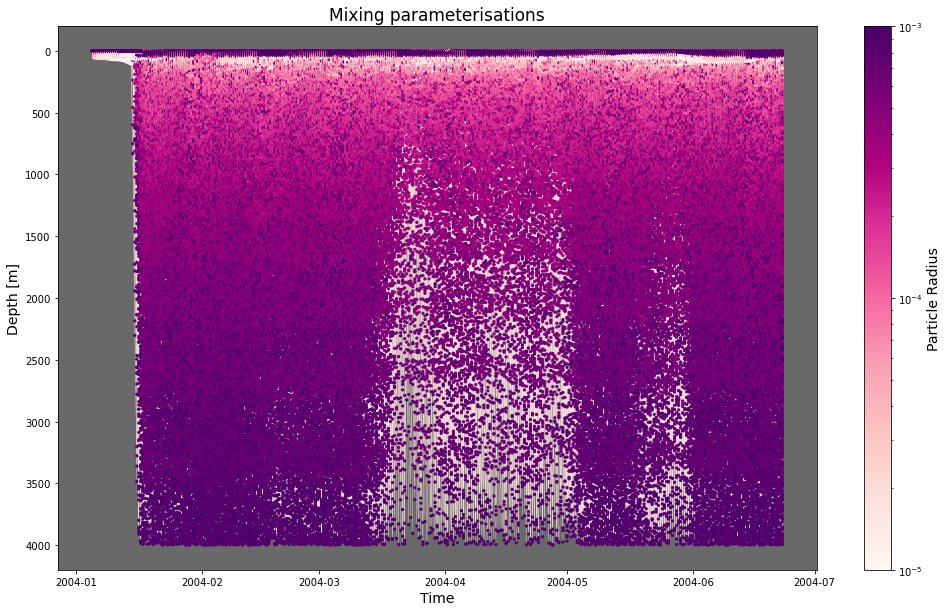

In [15]:
fig = plt.figure(figsize=(17,10))
ax = plt.axes()

sc = ax.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax.set_title('Mixing parameterisations', fontsize=17)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_facecolor('dimgray')
# ax.set_ylim(150,0)
ax.invert_yaxis()

cb = fig.colorbar(sc, ax=ax)
cb.set_label('Particle Radius', fontsize=14)
plt.show()

In [11]:
dead = ds['z']>ds['euphz']

Text(0.65, 0.02, '4.31 % below Euph_z')

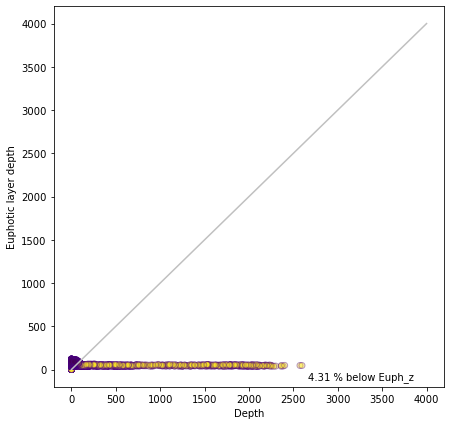

In [12]:
fig = plt.figure(figsize=(7,7))
ax=plt.axes()
ax.scatter(ds['z'].T[:,::f_plt], ds['euphz'].T[:,::f_plt],c=dead.T[:,::f_plt],marker='o', edgecolor='indigo',alpha=0.4)
ax.plot(np.linspace(0,np.max(ds['z'])),np.linspace(0,np.max(ds['z'])),color='silver')
ax.set_ylabel('Euphotic layer depth')
ax.set_xlabel('Depth')
ax.text(0.65,0.02,f'{np.round(np.count_nonzero(dead)/dead.size,4)*100} % below Euph_z', transform=ax.transAxes)
# ax.invert_yaxis()

In [13]:
below = np.divide(ds['z'],ds['mld'])>ds['euphz']

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


Text(0.65, 0.02, '10.6 % MLD below Euph_z')

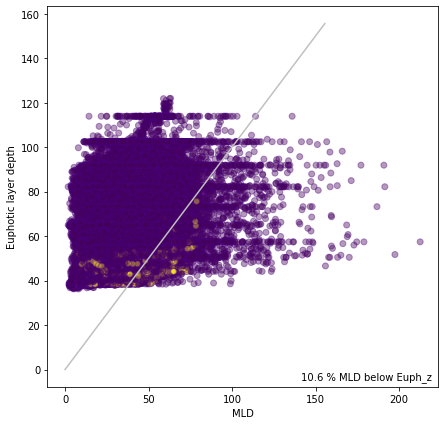

In [29]:
fig = plt.figure(figsize=(7,7))
ax=plt.axes()
ax.scatter(np.divide(ds['z'].T[:,::f_plt],ds['mld'].T[:,::f_plt]), ds['euphz'].T[:,::f_plt],c=dead.T[:,::f_plt],marker='o', edgecolor='indigo',alpha=0.4)
ax.plot(np.linspace(0,np.max(ds['euphz'])),np.linspace(0,np.max(ds['euphz'])),color='silver')
ax.set_ylabel('Euphotic layer depth')
ax.set_xlabel('MLD')
ax.text(0.65,0.02,f'{np.round(np.count_nonzero(below)/below.size,3)*100} % MLD below Euph_z', transform=ax.transAxes)
# ax.invert_yaxis()

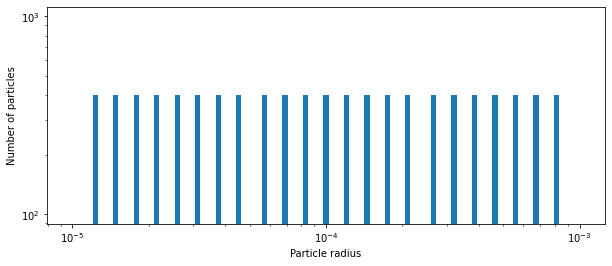

In [37]:
fig = plt.figure(figsize=(10,4))
ax=plt.axes()
ax.hist(ds['r_pl'],np.logspace(np.log10(ds['r_pl'].min()).round(),np.log10(ds['r_pl'].max()).round(),100))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of particles')
ax.set_xlabel('Particle radius')
plt.show()

In [17]:
split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))

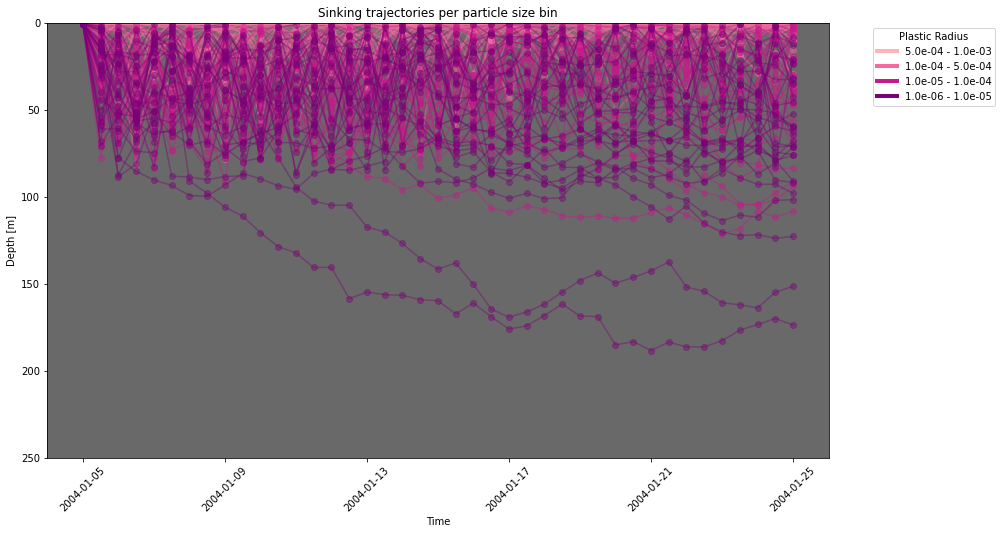

In [18]:
fig = plt.figure(figsize=(14,8))
ax=plt.axes()

for i, r in enumerate(split_ds):
    ax.plot(r[1]['time'].T[:,::f_plt], r[1]['z'].T[:,::f_plt], marker='o', markersize=6, c=r_pl_clist[i], alpha=0.4)
ax.set_facecolor('dimgray')
ax.set_ylim(250,0)
ax.set_title('Sinking trajectories per particle size bin')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)

custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
                Line2D([0], [0], color=r_pl_clist[1], lw=4),
                Line2D([0], [0], color=r_pl_clist[2], lw=4),
                Line2D([0], [0], color=r_pl_clist[3], lw=4)]

ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{:.1e} - {:.1e}".format(split_ds[1][0].left, split_ds[1][0].right), "{:.1e} - {:.1e}".format(split_ds[2][0].left, split_ds[2][0].right), "{:.1e} - {:.1e}".format(split_ds[3][0].left, split_ds[3][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()